In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import DBSCAN, KMeans
from sklearn.linear_model import LinearRegression, RANSACRegressor
from scipy.spatial.distance import cdist
from scipy.optimize import minimize_scalar
import os
import json

In [2]:
matches_df = pd.read_csv('matches.csv')

match_ids = matches_df['match_id'].astype(int).tolist()

team_mapping = {}
for _, row in matches_df.iterrows():
    team_mapping[row['home_team_id']] = row['home_team_name']
    team_mapping[row['away_team_id']] = row['away_team_name']
team_mapping = {int(k): v for k, v in team_mapping.items()}

off_ball_analysis = pd.read_csv("processed_csv/final_merged_off_ball_analysis.csv")

passing_analysis = pd.read_csv("processed_csv/final_merged_passing_analysis.csv")
passing_analysis = passing_analysis[passing_analysis['team_in_possession_phase_type']!='set_play']

possessions_analysis = pd.read_csv("processed_csv/final_merged_possessions_analysis.csv")
possessions_analysis = possessions_analysis[possessions_analysis['team_in_possession_phase_type']!='set_play']

passing_offball_merged = pd.read_csv("processed_csv/final_merged_passing_offball_merged.csv")
passing_offball_merged = passing_offball_merged[passing_offball_merged['team_in_possession_phase_type']!='set_play']


possessions_analysis['back_line_count'] = possessions_analysis['back_line_count'].astype(int)
passing_offball_merged['back_line_count'] = passing_offball_merged['back_line_count'].astype(int)
passing_analysis['back_line_count'] = passing_analysis['back_line_count'].astype(int)

possessions_order = sorted(passing_offball_merged["back_line_count"].dropna().unique())
# back_line_order=[3,4,5]
channel_order = ['wide_left', 'half_space_left', 'center', 'half_space_right', 'wide_right']
channel_order_formatted = ['wide left', 'half space left', 'center', 'half space right', 'wide right']
classified_channel_order=['Wide','Half-space','Central']
pass_range_order = ["short", "medium", "long"]
phase_type_order = ['chaotic','create','finish','quick break','transition','direct']

In [3]:
possessions_analysis['team_name'] = possessions_analysis['team_id'].map(team_mapping)
possessions_analysis = possessions_analysis.merge(
    matches_df[['match_id', 'competition_edition_name']],
    on='match_id',
    how='left'
)
possessions_analysis = possessions_analysis.rename(columns={'competition_edition_name': 'league'})

passing_analysis['team_name'] = passing_analysis['team_id'].map(team_mapping)
passing_analysis = passing_analysis.merge(
    matches_df[['match_id', 'competition_edition_name']],
    on='match_id',
    how='left'
)
passing_analysis = passing_analysis.rename(columns={'competition_edition_name': 'league'})

passing_offball_merged = passing_offball_merged.rename(columns={'match_id_x': 'match_id'})
passing_offball_merged['team_name'] = passing_offball_merged['team_id'].map(team_mapping)
passing_offball_merged = passing_offball_merged.merge(
    matches_df[['match_id', 'competition_edition_name']],
    on='match_id',
    how='left'
)
passing_offball_merged = passing_offball_merged.rename(columns={'competition_edition_name': 'league'})

In [ ]:
opponent_lookup = {}

for _, row in matches_df.iterrows():
    opponent_lookup[(row['match_id'], row['home_team_id'])] = row['away_team_id']
    opponent_lookup[(row['match_id'], row['away_team_id'])] = row['home_team_id']

possessions_analysis['opponent_id'] = possessions_analysis.apply(
    lambda r: opponent_lookup.get((r['match_id'], r['team_id'])), axis=1
)
possessions_analysis['opponent_name'] = possessions_analysis['opponent_id'].map(team_mapping)


passing_analysis['opponent_id'] = passing_analysis.apply(
    lambda r: opponent_lookup.get((r['match_id'], r['team_id'])), axis=1
)
passing_analysis['opponent_name'] = passing_analysis['opponent_id'].map(team_mapping)


passing_offball_merged['opponent_id'] = passing_offball_merged.apply(
    lambda r: opponent_lookup.get((r['match_id'], r['team_id'])), axis=1
)
passing_offball_merged['opponent_name'] = passing_offball_merged['opponent_id'].map(team_mapping)


In [5]:
colors = {
    3: '#1F77B4',
    4: '#FF7F0E',
    5: '#9467BD'
}
colors_str = {
    '3': '#1F77B4',
    '4': '#FF7F0E',
    '5': '#9467BD'
}


In [6]:
def run_on_buckets(func, df):
    for league in df['league'].unique():
        league_df = df[df['league'] == league]
        print(f"\n=== {league} ===")
        func(league_df, league)
        # for bucket_a in bucket_pairs:
        #     team_df = league_df[league_df['rank_bucket'] == bucket_a]
        #     for bucket_b in bucket_pairs:
                
        #         matchup_df = team_df[team_df['opponent_bucket'] == bucket_b]
        #         if matchup_df.empty:
        #             continue
        #         print(f"\n{bucket_a} vs {bucket_b}")
                
        #         func(matchup_df, league, bucket_a, bucket_b)

### Duration and xthreat conceded across formations



=== USA - NWSL - 2023 ===


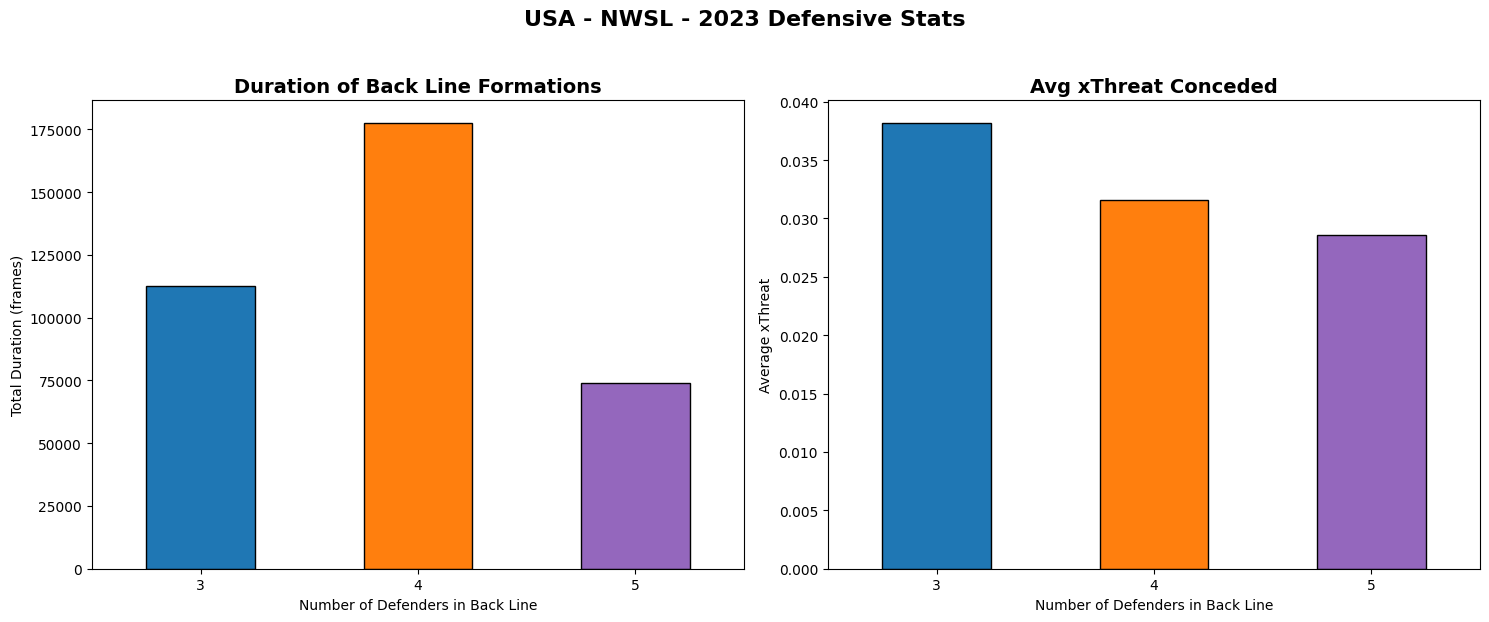


=== ENG - FA Women`s Super League - 2023/2024 ===


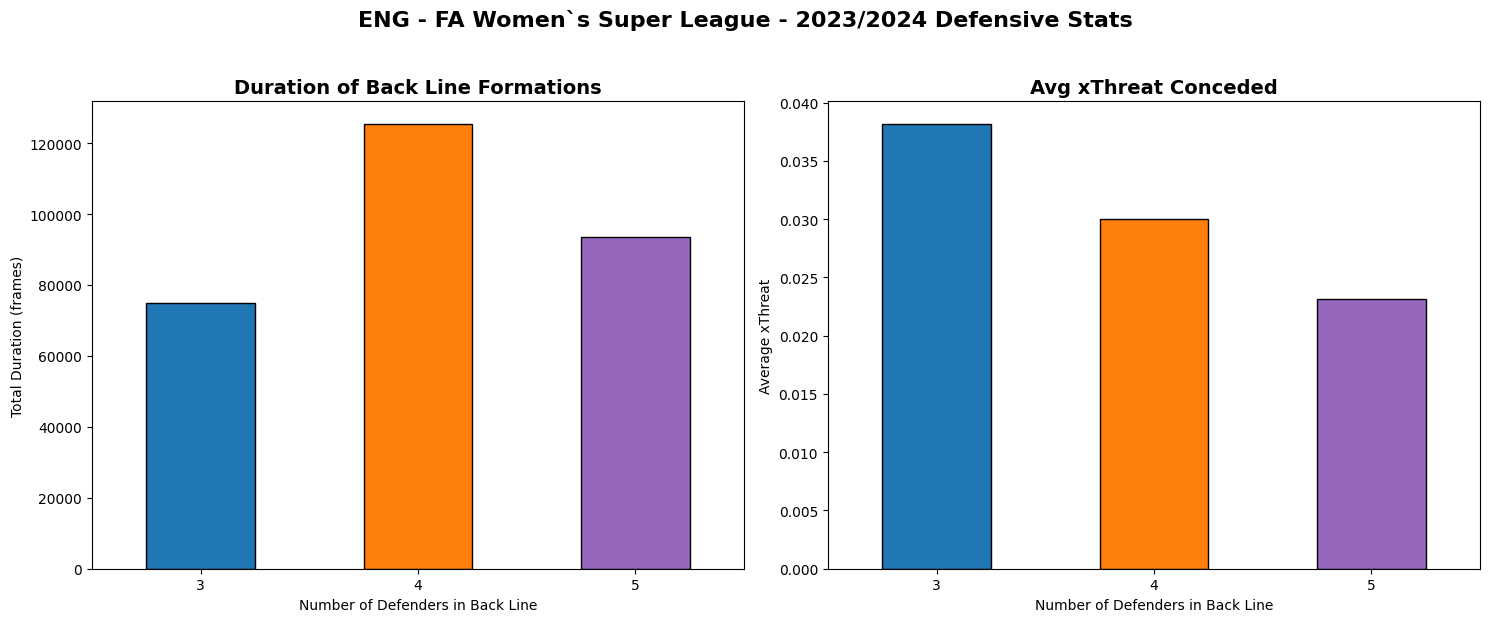

In [7]:
def analyze_formation_duration(df, league):
    if df is None or not all(col in df.columns for col in ['back_line_count', 'team_id', 'frame_start', 'frame_end', 'player_targeted_xthreat']):
        print("No data available or missing required columns")
        return

    df['duration'] = df['frame_end'] - df['frame_start']

    formation_summary = (
        df.groupby('back_line_count')
        .agg(total_duration=('duration', 'sum'),
            avg_xthreat=('player_targeted_xthreat', 'mean'))
        .sort_index()
        .reset_index()
    )

    bar_colors = [colors.get(x, '#CCCCCC') for x in formation_summary['back_line_count']]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    formation_summary.plot(
        x='back_line_count',
        y='total_duration',
        kind='bar',
        ax=ax1,
        color=bar_colors,
        edgecolor='black',
        legend=False
    )
    ax1.set_title(f'Duration of Back Line Formations', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Defenders in Back Line')
    ax1.set_ylabel('Total Duration (frames)')
    ax1.tick_params(axis='x', rotation=0)

    # sns.barplot(
    #     data=formation_summary,
    #     x='back_line_count',
    #     y='avg_xthreat',
    #     ax=ax2,
    #     palette=bar_colors
    # )
    formation_summary.plot(
        x='back_line_count',
        y='avg_xthreat',
        kind='bar',
        ax=ax2,
        color=bar_colors,
        edgecolor='black',
        legend=False
    )
    ax2.set_title(f'Avg xThreat Conceded', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Number of Defenders in Back Line')
    ax2.set_ylabel('Average xThreat')
    ax2.tick_params(axis='x', rotation=0)
    fig.suptitle(f'{league} Defensive Stats', fontsize=16, fontweight='bold', y=1.03)
    plt.tight_layout()
    plt.show()
                
        
run_on_buckets(analyze_formation_duration, possessions_analysis)

### Shot and Goal Conversion


=== USA - NWSL - 2023 ===


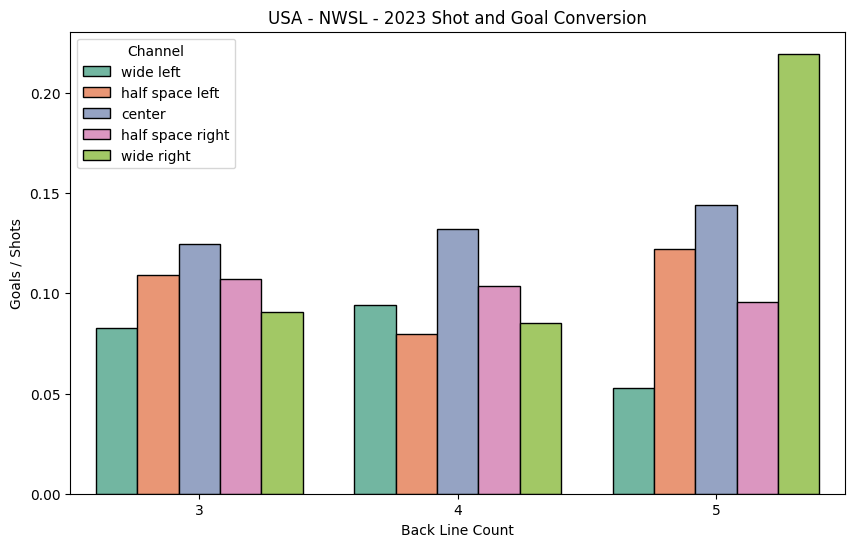


=== ENG - FA Women`s Super League - 2023/2024 ===


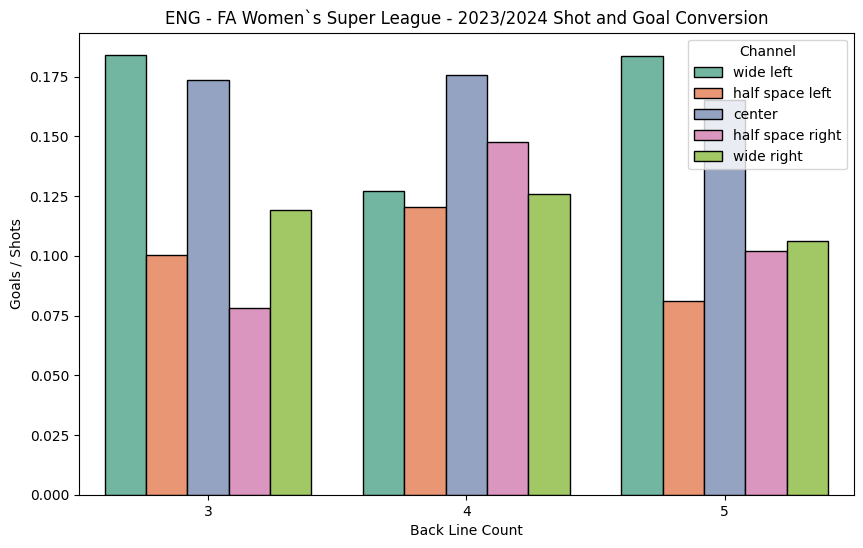

In [10]:
def analyze_shot_conversion(matchup_df, league):
    required_cols = [
        "back_line_count", "channel_end", "lead_to_shot", "lead_to_goal",
        "league"
    ]
    if matchup_df is None or not all(col in matchup_df.columns for col in required_cols):
        print("No data available or missing required columns")
        return

    conversion = (
        matchup_df
        .groupby(["back_line_count", "channel_end"])
        .agg(
            total_shots=("lead_to_shot", "sum"),
            total_goals=("lead_to_goal", "sum")
        )
        .reset_index()
    )

    conversion["goal_per_shot"] = conversion["total_goals"] / conversion["total_shots"]

    conversion["goal_per_shot"] = conversion["goal_per_shot"].fillna(0)

    temp_df = conversion.copy()
    temp_df['channel_end'] = temp_df['channel_end'].str.replace('_',' ')
    
    plt.figure(figsize=(10,6))
    sns.barplot(
        data=temp_df,
        x="back_line_count",
        y="goal_per_shot",
        hue="channel_end",
        hue_order=channel_order_formatted,
        palette="Set2",
        ci=None,
        edgecolor="black"
    )
    plt.title(f"{league} Shot and Goal Conversion")
    plt.ylabel("Goals / Shots")
    plt.xlabel("Back Line Count")
    plt.legend(title="Channel")
    plt.show()
                
run_on_buckets(analyze_shot_conversion, possessions_analysis)

### XThreat Across Channels


=== USA - NWSL - 2023 ===


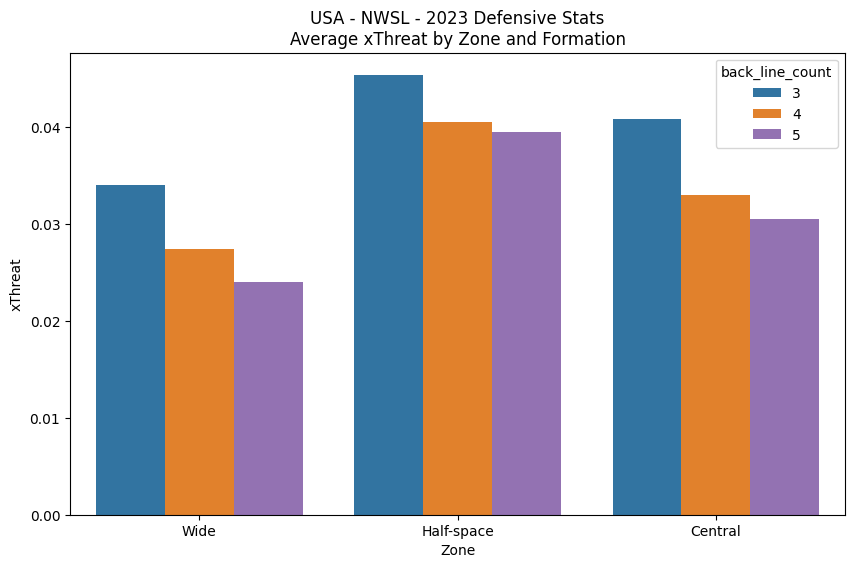


=== ENG - FA Women`s Super League - 2023/2024 ===


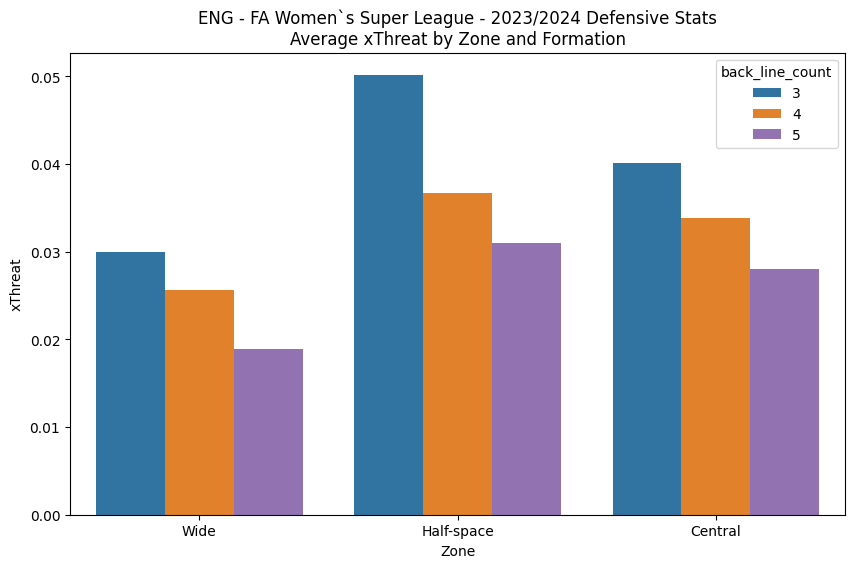

In [11]:
def classify_channel(c):
    if c in ['wide_right','wide_left']:  
        return "Wide"
    elif c in ['half_space_right','half_space_left']:  
        return "Half-space"
    else:
        return "Central"


def xthreat_across_channels(df, league):
    df["zone"] = df["channel_start"].apply(classify_channel)

    plt.figure(figsize=(10,6))
    sns.barplot(data=df, x="zone", y="player_targeted_xthreat",
                hue="back_line_count", ci=None, palette=colors, order=classified_channel_order)
    plt.title(f"{league} Defensive Stats\nAverage xThreat by Zone and Formation")
    plt.ylabel("xThreat")
    plt.xlabel("Zone")
    plt.show()
    
run_on_buckets(xthreat_across_channels, possessions_analysis)

### XThreat Across Phases


=== USA - NWSL - 2023 ===


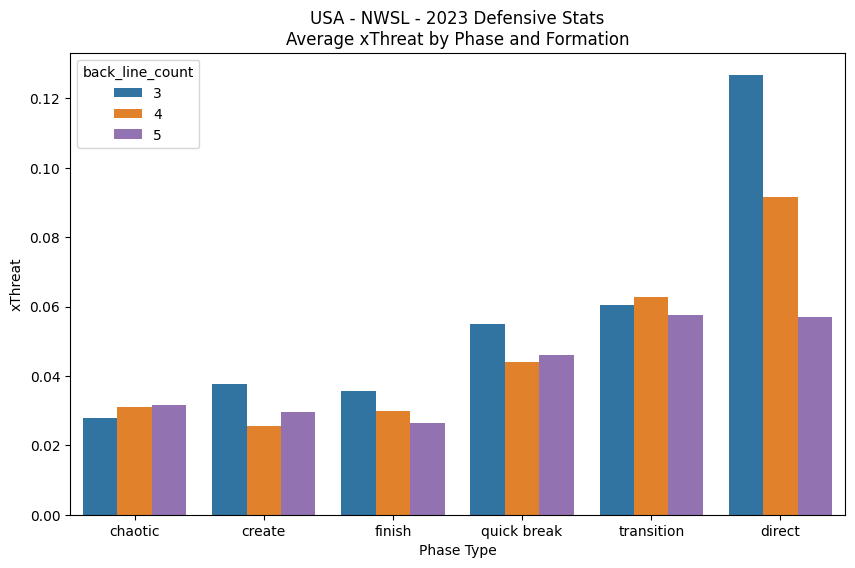


=== ENG - FA Women`s Super League - 2023/2024 ===


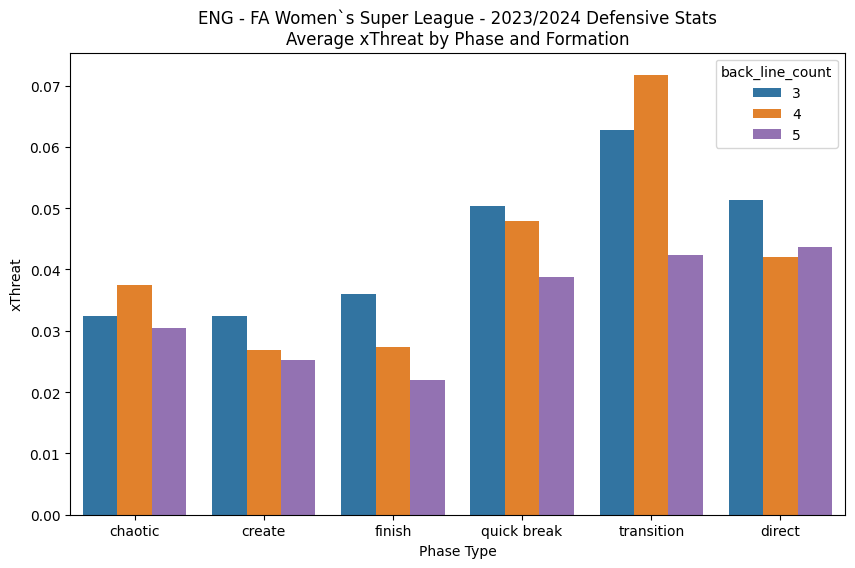

In [12]:
def xthreat_across_phases(df, league):
    temp_df = df.copy()
    temp_df['team_in_possession_phase_type'] = temp_df['team_in_possession_phase_type'].str.replace('_',' ')
    plt.figure(figsize=(10,6))
    sns.barplot(data=temp_df, x="team_in_possession_phase_type", y="player_targeted_xthreat",
                hue="back_line_count", ci=None, palette=colors, order=phase_type_order)
    plt.title(f"{league} Defensive Stats\nAverage xThreat by Phase and Formation")
    plt.ylabel("xThreat")
    plt.xlabel("Phase Type")
    plt.show()

run_on_buckets(xthreat_across_phases, possessions_analysis)

### Average Opponents Bypassed 


=== USA - NWSL - 2023 ===


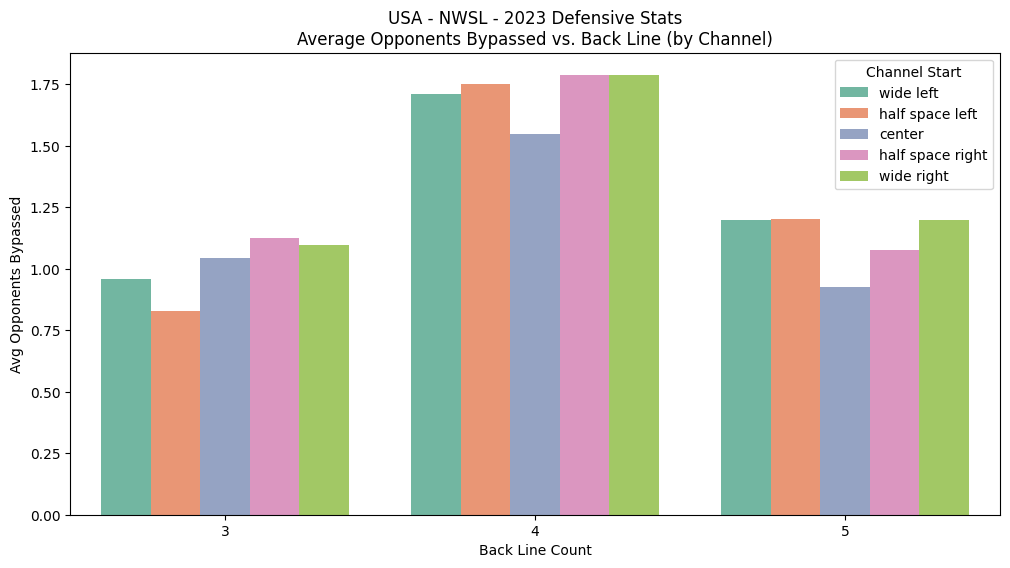


=== ENG - FA Women`s Super League - 2023/2024 ===


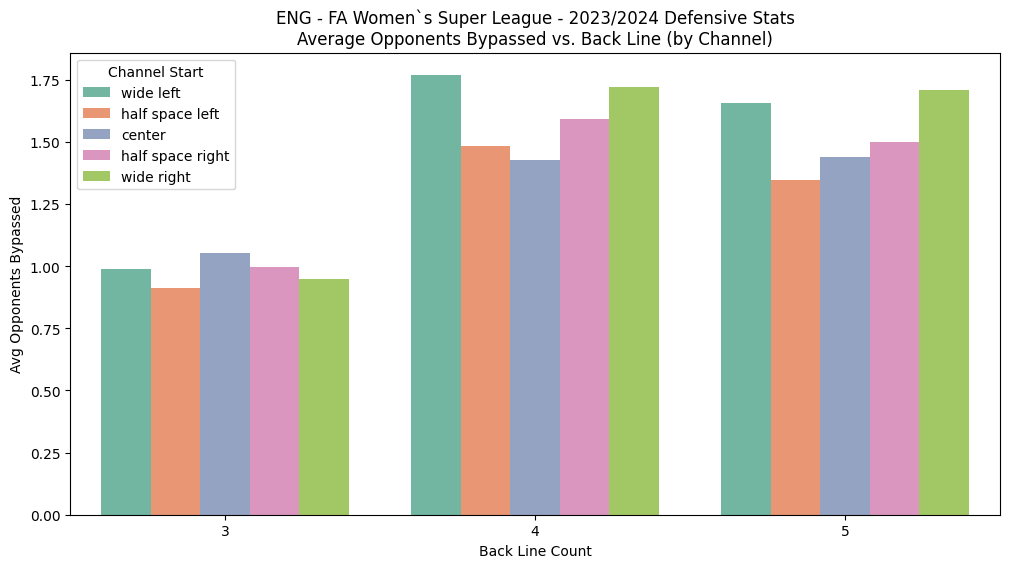

In [13]:
def opponents_bypassed(df, league):
    temp_df = df.copy()
    temp_df['channel_start_x'] = temp_df['channel_start_x'].str.replace('_',' ')
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=temp_df,
        x="back_line_count", 
        y="n_opponents_bypassed", 
        hue="channel_start_x", 
        order=possessions_order,
        hue_order=channel_order_formatted,
        estimator="mean",
        errorbar=None,
        palette="Set2"
    )
    plt.title(f"{league} Defensive Stats\nAverage Opponents Bypassed vs. Back Line (by Channel)")
    plt.ylabel("Avg Opponents Bypassed")
    plt.xlabel("Back Line Count")
    plt.legend(title="Channel Start")
    plt.show()
run_on_buckets(opponents_bypassed, passing_offball_merged)

### XPass Completion


=== USA - NWSL - 2023 ===


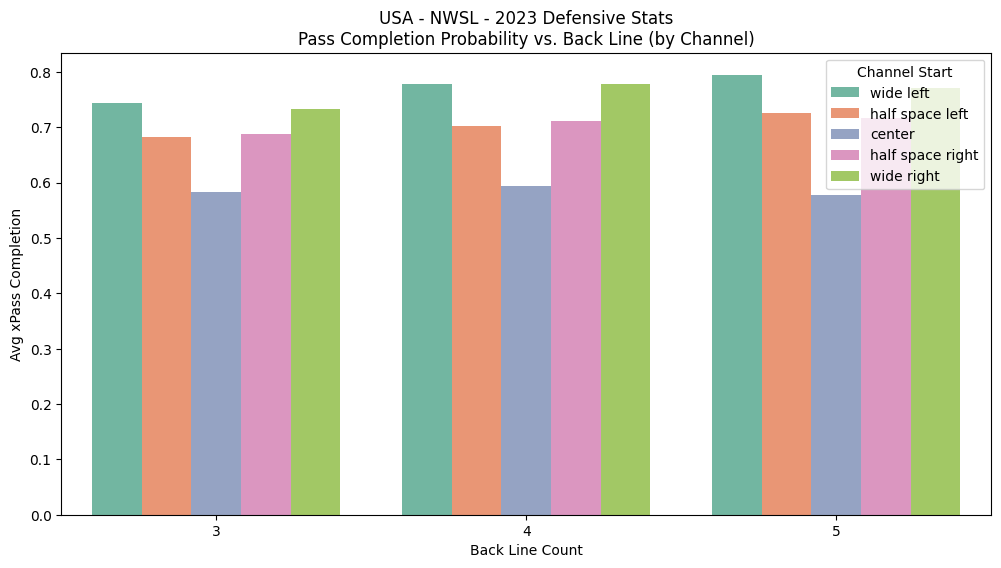


=== ENG - FA Women`s Super League - 2023/2024 ===


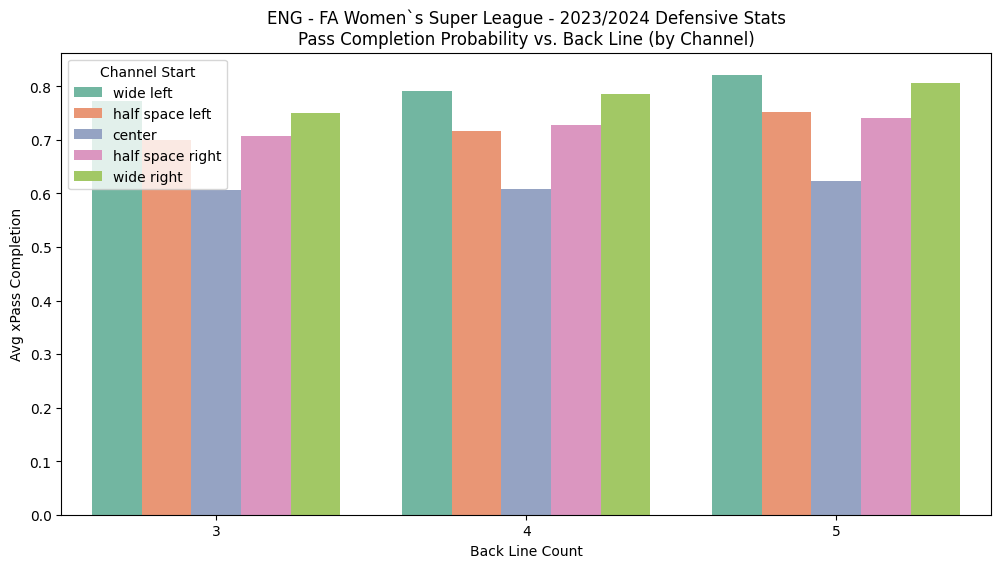

In [14]:
def xpass_completion(df, league):
    temp_df = df.copy()
    temp_df['channel_start_x'] = temp_df['channel_start_x'].str.replace('_',' ')
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=temp_df,
        x="back_line_count", 
        y="xpass_completion", 
        hue="channel_start_x", 
        order=possessions_order,
        hue_order=channel_order_formatted,
        estimator="mean",
        errorbar=None,
        palette="Set2"
    )
    plt.title(f"{league} Defensive Stats\nPass Completion Probability vs. Back Line (by Channel)")
    plt.ylabel("Avg xPass Completion")
    plt.xlabel("Back Line Count")
    plt.legend(title="Channel Start")
    plt.show()

run_on_buckets(xpass_completion, passing_offball_merged)

### Dangerous pass frequency


=== USA - NWSL - 2023 ===


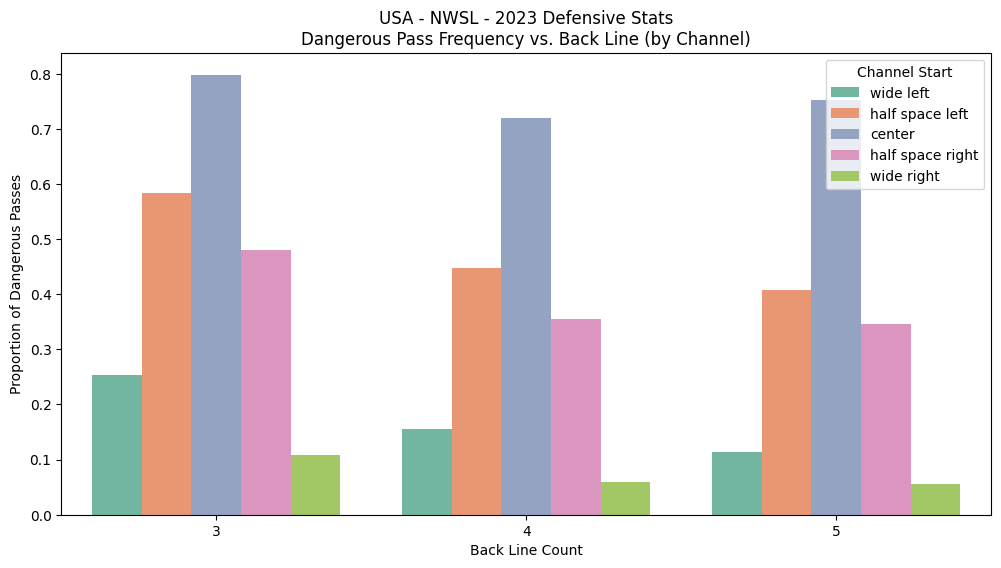


=== ENG - FA Women`s Super League - 2023/2024 ===


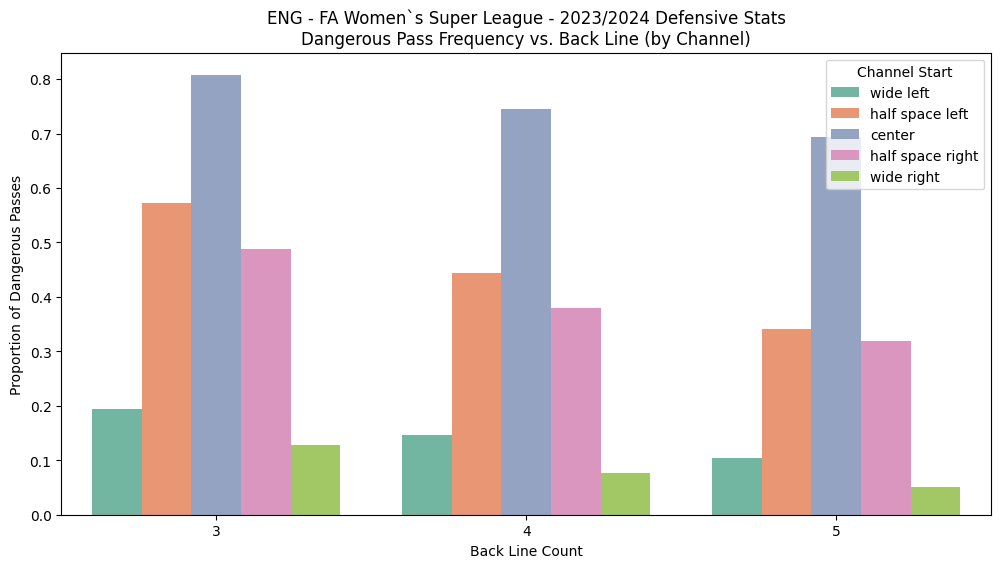

In [15]:
def dangerous_pass_frequency(df, league):
    temp_df = df.copy()
    temp_df['channel_start_x'] = temp_df['channel_start_x'].str.replace('_',' ')
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=temp_df,
        x="back_line_count", 
        y="dangerous_x", 
        hue="channel_start_x", 
        order=possessions_order,
        hue_order=channel_order_formatted,
        estimator="mean",
        errorbar=None,
        palette="Set2"
    )
    plt.title(f"{league} Defensive Stats\nDangerous Pass Frequency vs. Back Line (by Channel)")
    plt.ylabel("Proportion of Dangerous Passes")
    plt.xlabel("Back Line Count")
    plt.legend(title="Channel Start")
    plt.show()
    
run_on_buckets(dangerous_pass_frequency, passing_offball_merged)

### Dangerous Pass proportion across Channels


=== USA - NWSL - 2023 ===


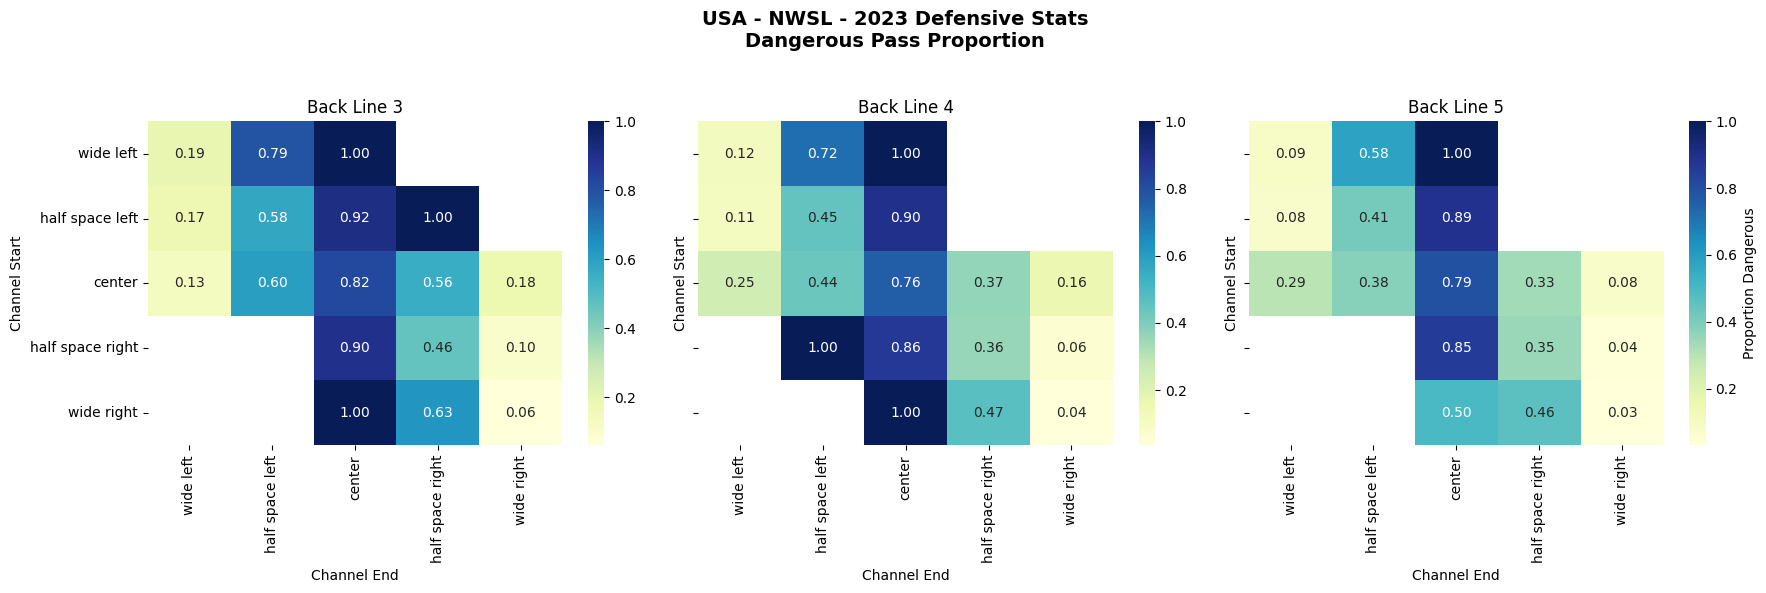


=== ENG - FA Women`s Super League - 2023/2024 ===


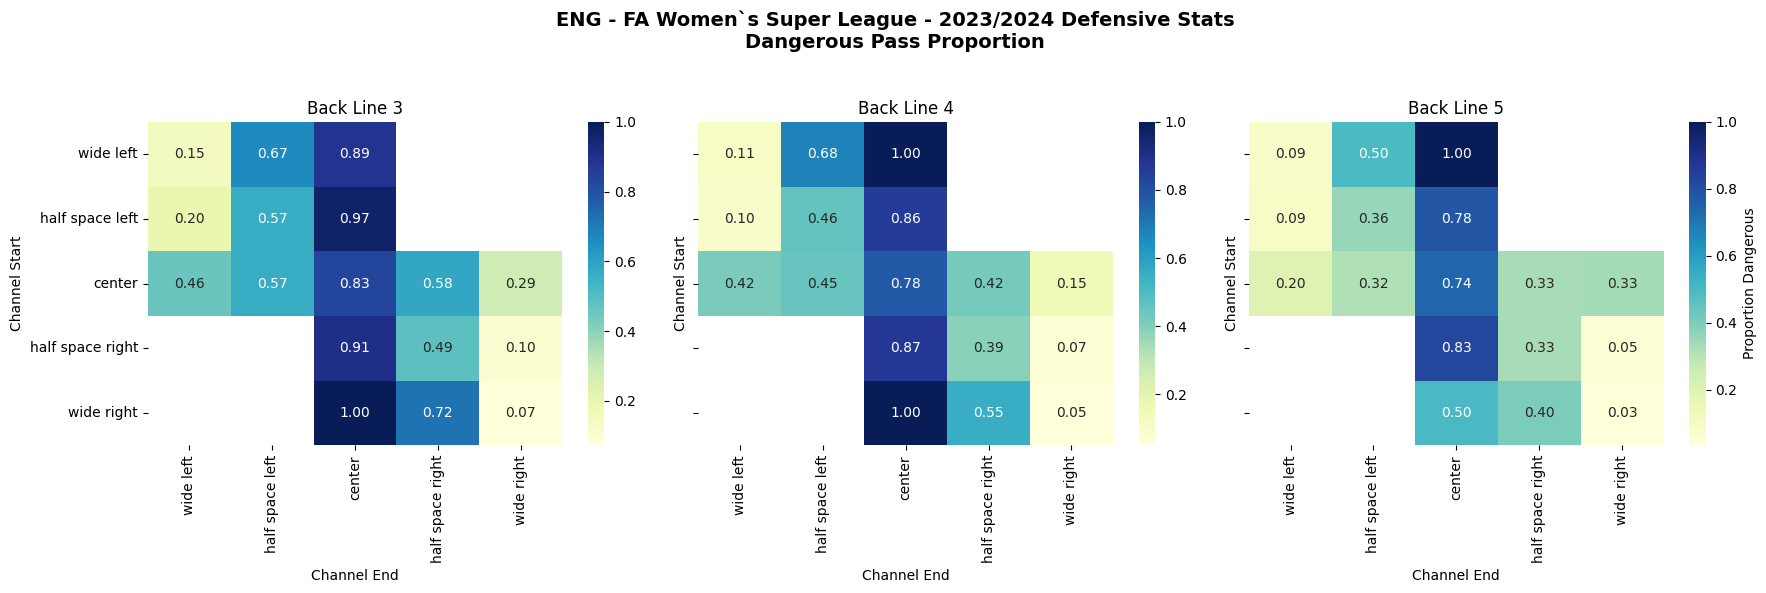

In [16]:
def dangerous_pass_proportion(df, league):
    
    temp_df = df.copy()
    temp_df['channel_start_x'] = temp_df['channel_start_x'].str.replace('_',' ')
    temp_df['channel_end_x'] = temp_df['channel_end_x'].str.replace('_',' ')
    back_line_counts = sorted(temp_df['back_line_count'].dropna().unique())
    n = len(back_line_counts)
    
    fig, axes = plt.subplots(1, n, figsize=(6*n, 6), sharex=True, sharey=True)
    
    if n == 1:
        axes = [axes]
    
    for ax, blc in zip(axes, back_line_counts):
        subset = temp_df[temp_df['back_line_count'] == blc]
        
        table = (
            subset.groupby(['channel_start_x', 'channel_end_x'])['dangerous_x']
            .mean()
            .unstack()
            .reindex(index=channel_order_formatted, columns=channel_order_formatted)

        )
        
        sns.heatmap(
            table,
            ax=ax,
            annot=True,
            fmt=".2f",
            cmap="YlGnBu",
            cbar_kws={"label": "Proportion Dangerous"} if ax == axes[-1] else None
        )
        
        ax.set_title(f"Back Line {blc}")
        ax.set_xlabel("Channel End")
        ax.set_ylabel("Channel Start")
        ax.tick_params(axis='y', rotation=0)
    
    fig.suptitle(
        f"{league} Defensive Stats\nDangerous Pass Proportion",
        fontsize=14, 
        fontweight='bold'
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


run_on_buckets(dangerous_pass_proportion, passing_offball_merged)

### Pass Range Distribution


=== USA - NWSL - 2023 ===


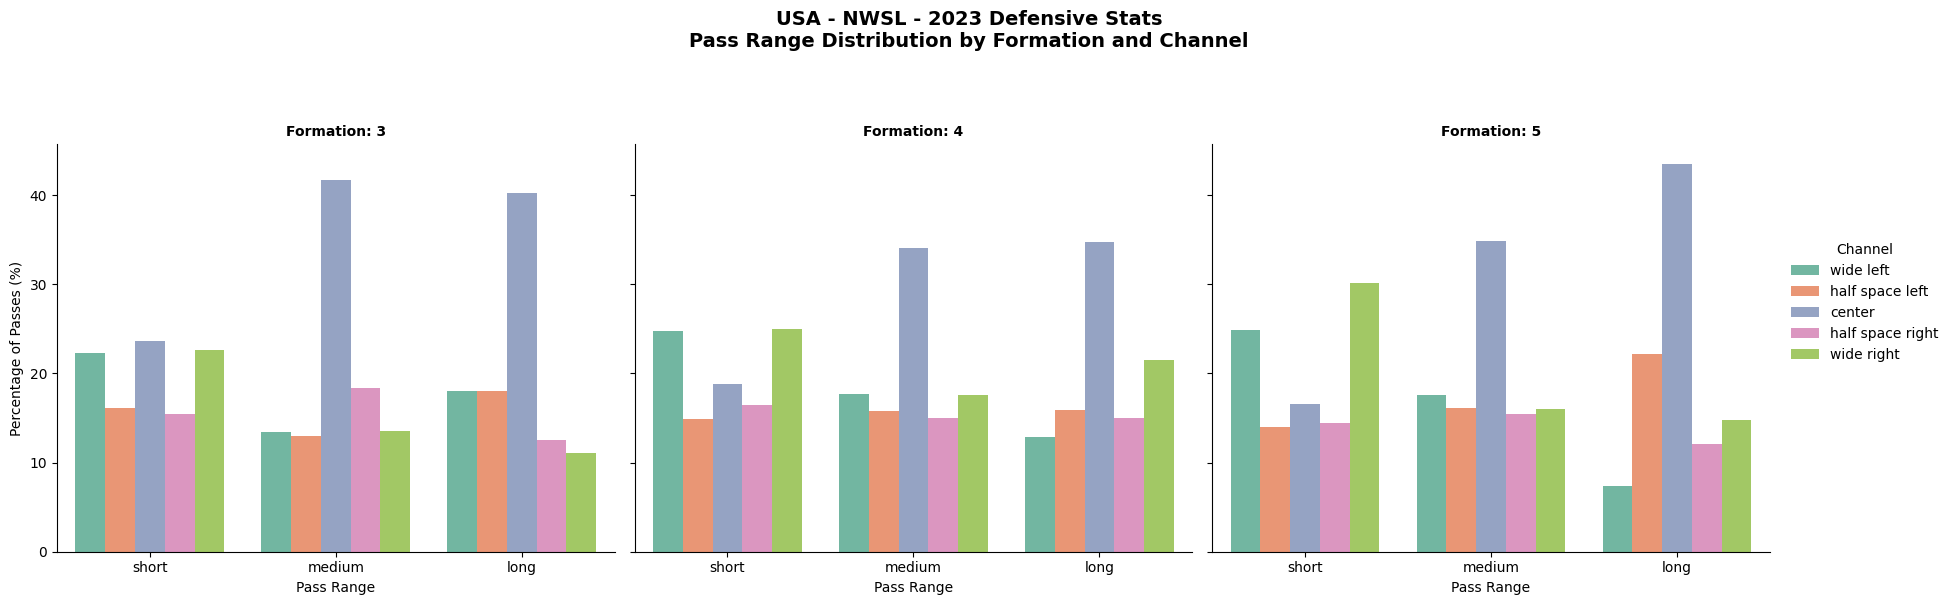


=== ENG - FA Women`s Super League - 2023/2024 ===


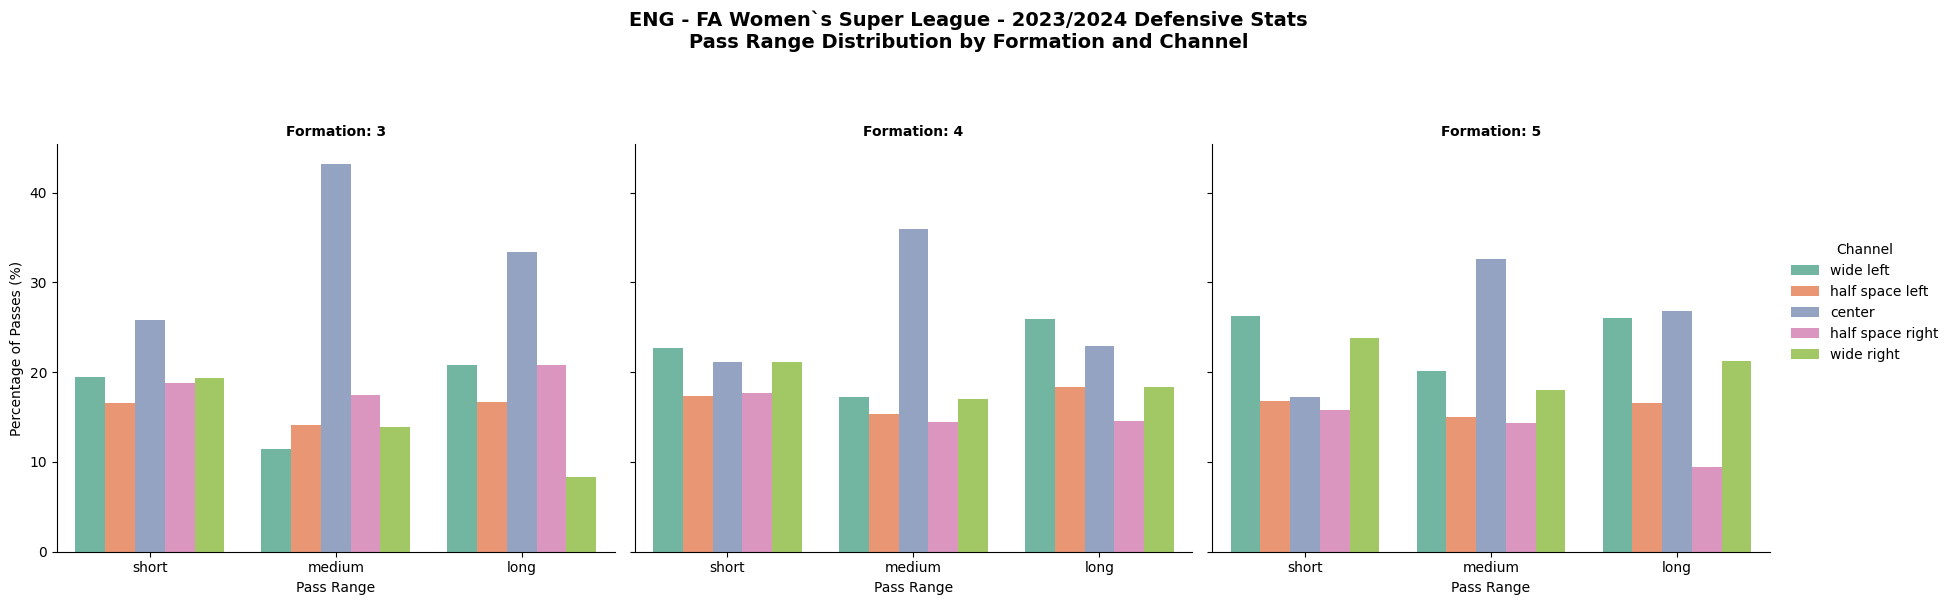

In [17]:
def pass_range(df, league):
    temp_df = df.copy()
    temp_df['channel_start_x'] = temp_df['channel_start_x'].str.replace('_',' ')
    dist = (
        temp_df.groupby(["back_line_count", "channel_start_x", "pass_range"])
        .size()
        .reset_index(name="count")
    )

    dist["pct"] = dist.groupby(["back_line_count", "pass_range"])["count"].transform(
        lambda x: x / x.sum() * 100
    )

    g = sns.catplot(
        data=dist,
        x="pass_range",
        y="pct",
        hue="channel_start_x",
        hue_order=channel_order_formatted,
        col="back_line_count",
        kind="bar",
        palette="Set2",
        height=5,
        aspect=1.2,
        order=pass_range_order
    )


    g.set_axis_labels("Pass Range", "Percentage of Passes (%)")
    g.set_titles("Formation: {col_name}", fontweight='bold')
    g._legend.set_title("Channel")
    plt.suptitle(f"{league} Defensive Stats\nPass Range Distribution by Formation and Channel", y=1.2, fontsize=14, fontweight="bold")
    plt.show()

run_on_buckets(pass_range, passing_offball_merged)